<a href="https://colab.research.google.com/github/WyvernCore/Deep-RL/blob/main/Linear_Function_Approx_using_Sarsa/SarsaMax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import matplotlib
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing
import pickle
import warnings
warnings.filterwarnings("ignore")

In [111]:
env = gym.make('MountainCar-v0')

In [112]:
num_episodes = 5000
discount_factor = 0.99
alpha = 0.01
nA = env.action_space.n

#Parameter vector define number of parameters per action based on featurizer size
w = np.zeros((nA,400))

In [113]:
# Plots
episode_rewards = np.zeros(num_episodes)

In [114]:
# Get satistics over observation space samples for normalization
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler()

In [115]:
# Create radial basis function sampler to convert states to features for nonlinear function approx
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
		])
# Fit featurizer to our scaled inputs
featurizer.fit(scaler.transform(observation_examples))
#featurizer.fit(observation_examples)

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [116]:
# Normalize and turn into feature
def featurize_state(state):
	# Transform data
	scaled = scaler.transform([state])
	featurized = featurizer.transform(scaled)
	#featurized = featurizer.transform([state])
	return featurized

In [117]:
def Q(state,action,w):
	value = state.dot(w[action])
	return value

In [118]:
def Q_Max(state,action,w):
  best_action = np.argmax([Q(state,a,w) for a in range(nA)])
  value = state.dot(w[best_action])
  return value

In [119]:
# Epsilon greedy policy
def policy(state, weight, epsilon=0.1):
	A = np.ones(nA,dtype=float) * epsilon/nA
	best_action =  np.argmax([Q(state,a,w) for a in range(nA)])
	A[best_action] += (1.0-epsilon)
	sample = np.random.choice(nA,p=A)
	return sample

In [120]:
# Helper function save params
def save_params(fname, param_list):
    file = open(fname+'.obj', 'wb')
    pickle.dump(param_list, file)
    file.close()

In [121]:
# Helper function load params
def load_params(fname):
    file = open(fname+'.obj', 'rb')
    param_list = pickle.load(file)
    return param_list

In [122]:
# Our main training loop
mov_avg_result = 0.

for e in range(num_episodes):

    state = env.reset()
    state = featurize_state(state)

    while True:

        #env.render()
        # Sample from our policy
        action = policy(state,w)
		
        # Step environment and get next state and make it a feature
        next_state, reward, done, _ = env.step(action)
        next_state = featurize_state(next_state)

        # Figure out what our policy tells us to do for the next state
        next_action = policy(next_state,w)

        # Statistic for graphing
        episode_rewards[e] += reward

        # Figure out target and td error

        # SARSA MAX
        target = reward + discount_factor * Q_Max(next_state,next_action,w)	
        

        # SARSA 
        #target = reward + discount_factor * Q(next_state,next_action,w)	

        td_error = target - Q(state,action,w)

        # gradient
        dw = (td_error).dot(state)

        # Update weight
        w[action] += alpha * dw

        if done:
          break
        # update our state
        state = next_state

    
    if e > 100:
        mov_avg_result = np.mean(episode_rewards[e-100:e])
        if mov_avg_result >= -137:
            print(f'Solved! Episode: {e} Average Score: {mov_avg_result}')
            save_params('weights2', [w, scaler, featurizer])
            break

    if e> 0 and e % 100 == 0:
        print(f'Episode: {e} Average Score: {mov_avg_result}')

Episode: 100 Average Score: 0.0
Solved! Episode: 190 Average Score: -136.79


In [123]:
w, scaler, featurizer = load_params('weights2')

In [124]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
from colabgymrender.recorder import Recorder
env = Recorder(env, './video')

In [126]:
done = False
s = env.reset()
while not done:
	s = featurize_state(s)	
	a = policy(s, w, 0)
	s, r, done, info = env.step(a)

In [127]:
env.play()

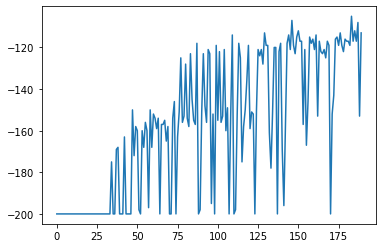

In [128]:
plt.plot(np.arange(e),episode_rewards[0:e])
plt.show()